In [2]:
%matplotlib inline

import scipy.stats as st
import numpy as np
import pandas as pd
from matplotlib import pyplot

## Container startup time distribution
The output of this section is an animation of the startup time of Eliot containers over a time series extracted from Prometheus. The dashboard panel "Container startup time" has been used, where the prometheus query is 
```
- sort(kube_pod_created{namespace="eliot"}) + kube_pod_start_time{namespace="eliot"}
```

To export the data you need to go the panel in Grafana, go for the query inspector and export the CSV with the "Join by time" option in the Transformer; be sure to choose the correct time frame.

In [82]:
np.random.seed(45873)
df = pd.read_csv("data/startup_time.csv")

Here we just show the final distribution

In [83]:
timestamp = df.tail(1)['Time']
containers_activation_time = df.tail(1).drop('Time', axis=1)
bins = np.arange(x_min,x_max, 0.5)

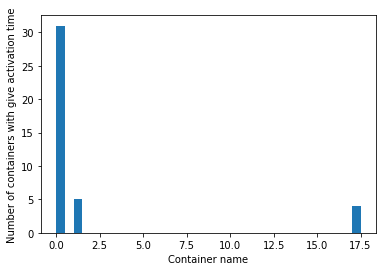

In [84]:
pyplot.hist(containers_activation_time, bins=bins)
pyplot.xlabel('Container name')
pyplot.ylabel('Number of containers with give activation time')
pyplot.show()

Here we generate the animation

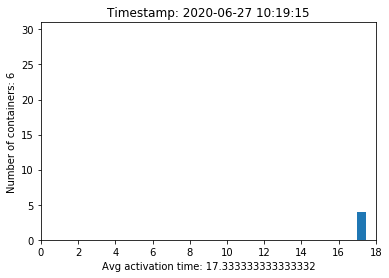

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()

# Get correct limits from last time series
containers_activation_time = df.iloc[-1][1:].dropna()
number_of_frames = len(df.index)
x_min, x_max = int(min(containers_activation_time)), int(max(containers_activation_time))
y_min, y_max = 0, containers_activation_time.value_counts().max()
bins = np.arange(x_min,x_max, 0.5)

def update_hist(i):
    pyplot.cla()
    timestamp = df.iloc[i][0]
    containers_activation_time = df.iloc[i][1:].dropna()

    pyplot.hist(containers_activation_time, bins)
    pyplot.xlabel('Avg activation time: ' + str(np.mean(containers_activation_time)))
    pyplot.ylabel('Number of containers: ' + str(len(containers_activation_time)))
    pyplot.title('Timestamp: ' + timestamp)
    pyplot.xlim(x_min,x_max)
    pyplot.ylim(y_min,y_max)
    
animation = animation.FuncAnimation(fig, update_hist, number_of_frames, repeat=False)
animation.save('containers_startup_time.mp4')
plt.show()



## System Load of a single test

In [8]:
TEST_NUMBER = 6
RUN_NUMBER = 3

#Retrieve the start and the end time for each test
def retrieve_test_times(index):
    start_time = []
    end_time = []

    for test in test_times:
        time = test.split(",")
        date = time[0] + " " + time[1]
        if "Starting test " + str(index) in test:
            start_time.append(date)
        elif "Test " + str(index) + " stabilization period elapsed" in test:
            end_time.append(date)
    return start_time, end_time


#Trasform NAN value in value
def trasform_nan_to_value(test_values):
    prev_value = 0
    for i in range(len(test_values)):
        if i > 0:
            prev_value = test_values[i-1]
        if pd.isna(test_values[i]):
            test_values[i] = prev_value
    return test_values


#Retrieve total seconds
def retrieve_total_seconds(start_time, end_time):
    start_datetime =pd.to_datetime(start_time, format='%Y-%m-%d %H:%M:%S')
    end_datetime = pd.to_datetime(end_time, format='%Y-%m-%d %H:%M:%S')
    delta_time = end_datetime - start_datetime
    seconds = delta_time.total_seconds()
    return seconds

#Get the minimum duration and scale the values to that duration
def fix_duration(values, times):
    min = 1000
    for time in times:
        if time < min:
            min = time
    
    new_values = []
    for value in values:
        new_value = []
        for index in range(int(min)):
            new_value.append(value[index])
        new_values.append(new_value)
    return min, new_values

def compute_mean(values, length):
    mean = []
    for i in range(length):
        total = 0
        for j in range(RUN_NUMBER):
            total += values[j][i]
        mean_value = total/RUN_NUMBER
        mean.append(mean_value)
    return mean

In [3]:
df_sl01 = pd.read_csv("data/system-load/system_load01.csv")
print(df_sl01)
df_sl02 = pd.read_csv("data/system-load/system_load02.csv")
print(df_sl02)
df_sl03 = pd.read_csv("data/system-load/system_load03.csv")
print(df_sl03)


test_times_file = open("data/system-load/test_times.log", "r")
test_times = test_times_file.readlines()
print(test_times)

                     Time      Value
0     2020-08-20 18:55:58   5.286667
1     2020-08-20 18:55:59   5.240000
2     2020-08-20 18:56:00   5.240000
3     2020-08-20 18:56:01   5.240000
4     2020-08-20 18:56:02   5.240000
...                   ...        ...
3311  2020-08-20 19:51:09  27.440000
3312  2020-08-20 19:51:10  27.400000
3313  2020-08-20 19:51:11  27.400000
3314  2020-08-20 19:51:12  27.400000
3315  2020-08-20 19:51:13  27.400000

[3316 rows x 2 columns]
                     Time  Value
0     2020-08-20 20:30:53   9.34
1     2020-08-20 20:30:54   9.34
2     2020-08-20 20:30:55   9.34
3     2020-08-20 20:30:56   9.34
4     2020-08-20 20:30:57   9.69
...                   ...    ...
3294  2020-08-20 21:25:47  42.08
3295  2020-08-20 21:25:48  42.08
3296  2020-08-20 21:25:49  42.08
3297  2020-08-20 21:25:50  42.08
3298  2020-08-20 21:25:51  42.08

[3299 rows x 2 columns]
                     Time  Value
0     2020-08-20 21:33:41   3.05
1     2020-08-20 21:33:42   3.05
2     2020-

In [4]:
test_time = {}
start_time = []
end_time = []

for index in range(TEST_NUMBER):
    start_time, end_time = retrieve_test_times(index + 1)
    test_time["Start_0" + str(index + 1)] = start_time
    test_time["End_0" + str(index + 1)] = end_time

In [5]:
df_sl = 0
dict_test_values = {}

for i in range(TEST_NUMBER):
    dict_test_values["Test_" + str(i + 1) + "_values"] = []
    dict_test_values["Test_" + str(i + 1) + "_time"] = []
    for j in range(RUN_NUMBER):
        if j == 0:
            df_sl = df_sl01
        elif j == 1:
            df_sl = df_sl02
        else:
            df_sl = df_sl03
            
        test_interval = pd.Interval(pd.Timestamp(test_time["Start_0" + str(i + 1)][j]), pd.Timestamp(test_time["End_0" + str(i + 1)][j]), closed="left")
        test_values = []
        test_seconds = []
        
        for time in df_sl["Time"]:
            index = df_sl[df_sl['Time']==time].index.values.astype(int)[0]
            time = pd.to_datetime(time, format='%Y-%m-%d %H:%M:%S')
            if time in test_interval:
                test_values.append(df_sl["Value"][index])

        test_values = trasform_nan_to_value(test_values)
        total_seconds = retrieve_total_seconds(test_time["Start_0" + str(i + 1)][j], test_time["End_0" + str(i + 1)][j])
        
        dict_test_values["Test_" + str(i + 1) + "_values"].append(test_values)
        dict_test_values["Test_" + str(i + 1) + "_time"].append(total_seconds)

In [6]:
for i in range(TEST_NUMBER):
    print(dict_test_values["Test_" + str(i + 1) + "_time"])
    print(len(dict_test_values["Test_" + str(i + 1) + "_values"][0]))

[496.0, 494.0, 494.0]
496
[515.0, 525.0, 517.0]
515
[527.0, 538.0, 528.0]
527
[527.0, 538.0, 579.0]
527
[506.0, 517.0, 516.0]
506
[504.0, 506.0, 504.0]
504


In [7]:
for index_test in range(TEST_NUMBER):
    times = dict_test_values["Test_" + str(index_test + 1) + "_time"]
    values = dict_test_values["Test_" + str(index_test + 1) + "_values"]
    dict_test_values["Test_" + str(index_test + 1) + "_time"], dict_test_values["Test_" + str(index_test + 1) + "_values"] = fix_duration(values, times)

In [8]:
for index_test in range(TEST_NUMBER):
    length = int(dict_test_values["Test_" + str(index_test + 1) + "_time"])
    dict_test_values["Test_" + str(index_test + 1) + "_mean"] = compute_mean(dict_test_values["Test_" + str(index_test + 1) + "_values"], length)

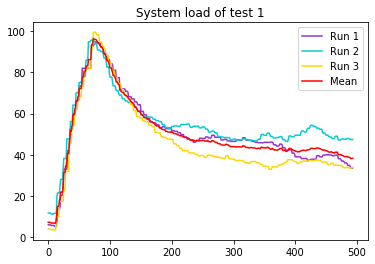

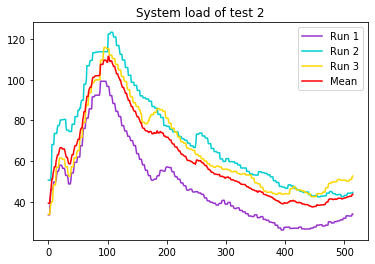

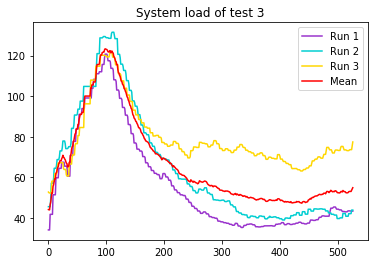

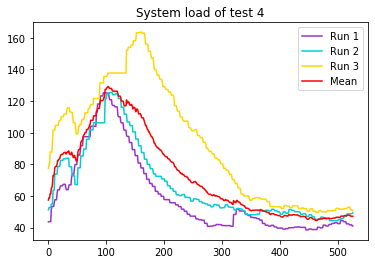

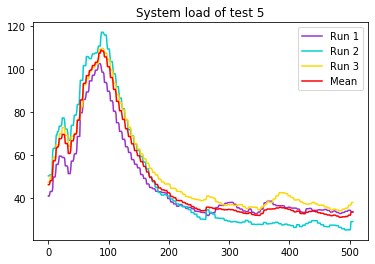

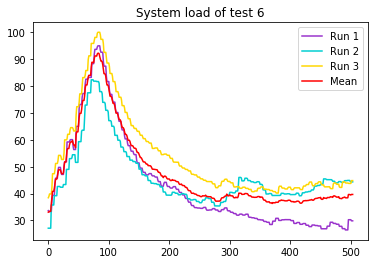

In [9]:
import matplotlib.pyplot as plt

for index_test in range(TEST_NUMBER):
    fig, ax = plt.subplots()
    for index in range(RUN_NUMBER):
        x = range(int(dict_test_values["Test_" + str(index_test + 1) + "_time"]))
        y = dict_test_values["Test_" + str(index_test + 1) + "_values"][index]
        
        line_color = "gold"
        if(index == 0):
            line_color = "darkorchid"
        elif(index == 1):
            line_color = "darkturquoise"
        
        ax.plot(x, y, '-', label='Run ' + str(index + 1), color=line_color)
    x = range(int(dict_test_values["Test_" + str(index_test + 1) + "_time"]))
    y = dict_test_values["Test_" + str(index_test + 1) + "_mean"]
    ax.plot(x, y, '-', label='Mean', color="red")
    ax.set_title('System load of test ' + str(index_test + 1))
    leg = ax.legend();
    plt.show()

## System Load of all tests

In [10]:
dict_test = {}
dict_test["values"] = []
dict_test["times"] = []
for index_test in range(TEST_NUMBER):
    dict_test["values"].append(dict_test_values["Test_" + str(index_test + 1) + "_mean"])
    dict_test["times"].append(dict_test_values["Test_" + str(index_test + 1) + "_time"])

dict_test["times"], dict_test["values"] = fix_duration(dict_test["values"], dict_test["times"])

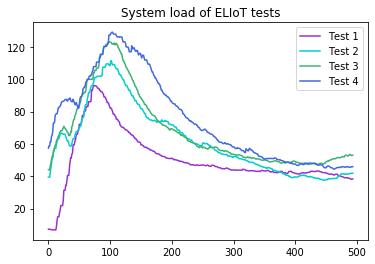

In [13]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER - 2):
    x = range(int(dict_test["times"]))
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
ax.set_title('System load of ELIoT tests')
plt.show()

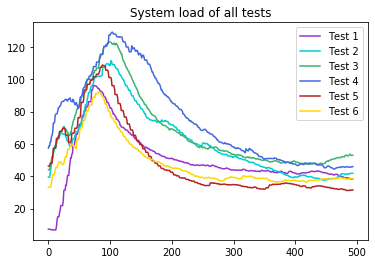

In [12]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER):
    x = range(int(dict_test["times"]))
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
ax.set_title('System load of all tests')
plt.show()

# Memory of single test

In [54]:
TEST_NUMBER = 6
RUN_NUMBER = 1

def from_two_seconds_to_one(values):
    new_values = []
    for value in values:
        new_values.append(value)
        new_values.append(value)
    return new_values

#Get the minimum duration and scale the values to that duration
def fix_duration(values, times):
    min = 1000
    for value in values:
        if len(value) < min:
            min = len(value)
    
    new_values = []
    for value in values:
        new_value = []
        for index in range(int(min)):
            new_value.append(value[index])
        new_values.append(new_value)
    return min, new_values

In [55]:
df_m01 = pd.read_csv("data/memory/memory01.csv")
print(df_m01)
#df_m02 = pd.read_csv("data/memory/memory02.csv")
#print(df_sl02)
#df_m03 = pd.read_csv("data/memory/memory03.csv")
#print(df_sl03)


test_times_file = open("data/memory/test_times.log", "r")
test_times = test_times_file.readlines()
print(test_times)

                     Time      Value
0     2020-08-23 13:30:32  22.084094
1     2020-08-23 13:30:34  22.082534
2     2020-08-23 13:30:36  22.072702
3     2020-08-23 13:30:38  22.085417
4     2020-08-23 13:30:40  22.083513
...                   ...        ...
1632  2020-08-23 14:24:56  33.139974
1633  2020-08-23 14:24:58  33.134032
1634  2020-08-23 14:25:00  33.128688
1635  2020-08-23 14:25:02  33.147559
1636  2020-08-23 14:25:04  33.151468

[1637 rows x 2 columns]
['2020-08-23,13:31:32,CEST Starting test 1: delta: 10 seconds, step_up 50, step_down: \n', '2020-08-23,13:39:35,CEST Test 1 stabilization period elapsed, test completed\n', '2020-08-23,13:39:35,CEST Starting test 2: delta: 20 seconds, step_up 50, step_down: \n', '2020-08-23,13:47:58,CEST Test 2 stabilization period elapsed, test completed\n', '2020-08-23,13:47:58,CEST Starting test 3: delta: 10 seconds, step_up 100, step_down: \n', '2020-08-23,13:56:12,CEST Test 3 stabilization period elapsed, test completed\n', '2020-08-23,1

In [56]:
test_time = {}
start_time = []
end_time = []

for index in range(TEST_NUMBER):
    start_time, end_time = retrieve_test_times(index + 1)
    test_time["Start_0" + str(index + 1)] = start_time
    test_time["End_0" + str(index + 1)] = end_time

In [57]:
df_m = 0
dict_test_values = {}

for i in range(TEST_NUMBER):
    dict_test_values["Test_" + str(i + 1) + "_values"] = []
    dict_test_values["Test_" + str(i + 1) + "_time"] = []
    for j in range(RUN_NUMBER):
        if j == 0:
            df_m = df_m01
        elif j == 1:
            df_m = df_m02
        else:
            df_m = df_m03
            
        test_interval = pd.Interval(pd.Timestamp(test_time["Start_0" + str(i + 1)][j]), pd.Timestamp(test_time["End_0" + str(i + 1)][j]), closed="left")
        test_values = []
        test_seconds = []
        
        for time in df_m["Time"]:
            index = df_m[df_m['Time']==time].index.values.astype(int)[0]
            time = pd.to_datetime(time, format='%Y-%m-%d %H:%M:%S')
            if time in test_interval:
                test_values.append(df_m["Value"][index])

        test_values = trasform_nan_to_value(test_values)
        total_seconds = retrieve_total_seconds(test_time["Start_0" + str(i + 1)][j], test_time["End_0" + str(i + 1)][j])
        
        dict_test_values["Test_" + str(i + 1) + "_values"].append(test_values)
        dict_test_values["Test_" + str(i + 1) + "_time"].append(total_seconds)

In [58]:
for index in range(TEST_NUMBER):
    new_values = []
    for run in range(RUN_NUMBER):
        run_values =  dict_test_values['Test_' + str(index + 1) +'_values'][run]
        new_values.append(from_two_seconds_to_one(run_values))
        dict_test_values['Test_' + str(index + 1) +'_values'] = new_values  

484
[483.0]


In [59]:
for index_test in range(TEST_NUMBER):
    times = dict_test_values["Test_" + str(index_test + 1) + "_time"]
    print(times)
    values = dict_test_values["Test_" + str(index_test + 1) + "_values"]
    print(values)
    dict_test_values["Test_" + str(index_test + 1) + "_time"], dict_test_values["Test_" + str(index_test + 1) + "_values"] = fix_duration(values, times)

[483.0]
[[22.10249072820755, 22.10249072820755, 22.10112077550473, 22.10112077550473, 22.099810128113713, 22.099810128113713, 22.109370144377603, 22.109370144377603, 22.10203407730661, 22.10203407730661, 22.112904740961515, 22.112904740961515, 22.213373869700064, 22.213373869700064, 23.992313794368076, 23.992313794368076, 25.43794007506629, 25.43794007506629, 25.0750745942212, 25.0750745942212, 26.18596983399731, 26.18596983399731, 26.18596983399731, 26.18596983399731, 26.18596983399731, 26.18596983399731, 29.274914280102312, 29.274914280102312, 30.42554645100409, 30.42554645100409, 31.064567116295816, 31.064567116295816, 32.20637821511887, 32.20637821511887, 33.368459869518816, 33.368459869518816, 33.63437302661575, 33.63437302661575, 33.14012255798517, 33.14012255798517, 33.628246787905695, 33.628246787905695, 34.37303847681186, 34.37303847681186, 34.6025085198011, 34.6025085198011, 34.6025085198011, 34.6025085198011, 34.6025085198011, 34.6025085198011, 34.6025085198011, 34.602508519

In [62]:
for index_test in range(TEST_NUMBER):
    length = int(dict_test_values["Test_" + str(index_test + 1) + "_time"])
    dict_test_values["Test_" + str(index_test + 1) + "_mean"] = compute_mean(dict_test_values["Test_" + str(index_test + 1) + "_values"], length)

[37.913156385260585, 37.913156385260585, 34.333469972771745, 34.333469972771745, 31.538760528472004, 31.538760528472004, 29.34852047480307, 29.34852047480307, 28.987256237376872, 28.987256237376872, 28.58159604352915, 28.58159604352915, 28.17599515499325, 28.17599515499325, 27.431600811676226, 27.431600811676226, 26.872766858483768, 26.872766858483768, 26.254983425351462, 26.254983425351462, 26.06209882921825, 26.06209882921825, 26.02057918041957, 26.02057918041957, 25.951274993037554, 25.951274993037554, 25.914891184241682, 25.914891184241682, 25.894757030881934, 25.894757030881934, 25.850052686839014, 25.850052686839014, 25.83822720766395, 25.83822720766395, 26.76095262359583, 26.76095262359583, 28.38829631021328, 28.38829631021328, 28.42304329240318, 28.42304329240318, 29.128829877731423, 29.128829877731423, 30.113851965401764, 30.113851965401764, 31.766967368319673, 31.766967368319673, 33.76595965246138, 33.76595965246138, 34.67420864178025, 34.67420864178025, 34.6031668087622, 34.

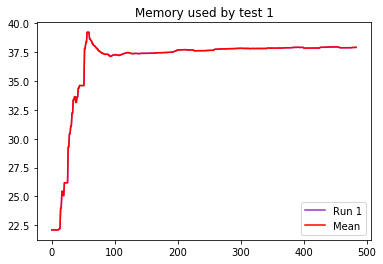

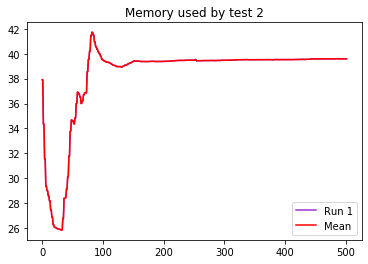

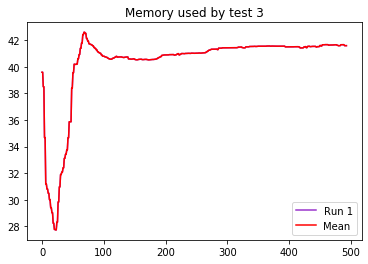

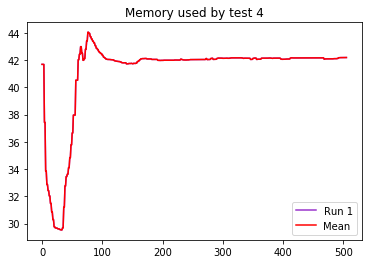

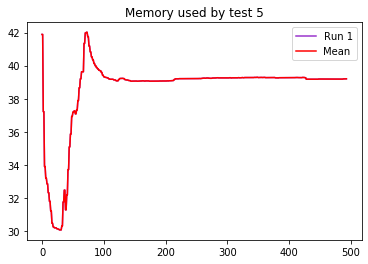

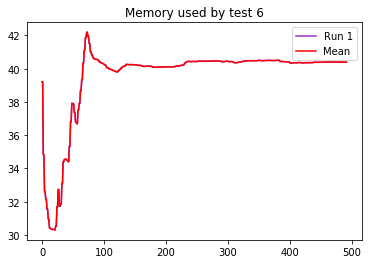

In [66]:
import matplotlib.pyplot as plt

for index_test in range(TEST_NUMBER):
    fig, ax = plt.subplots()
    for index in range(RUN_NUMBER):
        x = range(int(dict_test_values["Test_" + str(index_test + 1) + "_time"]))
        y = dict_test_values["Test_" + str(index_test + 1) + "_values"][index]
        
        line_color = "gold"
        if(index == 0):
            line_color = "darkorchid"
        elif(index == 1):
            line_color = "darkturquoise"
        
        ax.plot(x, y, '-', label='Run ' + str(index + 1), color=line_color)
    x = range(int(dict_test_values["Test_" + str(index_test + 1) + "_time"]))
    y = dict_test_values["Test_" + str(index_test + 1) + "_mean"]
    ax.plot(x, y, '-', label='Mean', color="red")
    ax.set_title('Memory used by test ' + str(index_test + 1))
    leg = ax.legend();
    plt.show()

# Memory of all tests

In [67]:
dict_test = {}
dict_test["values"] = []
dict_test["times"] = []
for index_test in range(TEST_NUMBER):
    dict_test["values"].append(dict_test_values["Test_" + str(index_test + 1) + "_mean"])
    dict_test["times"].append(dict_test_values["Test_" + str(index_test + 1) + "_time"])

dict_test["times"], dict_test["values"] = fix_duration(dict_test["values"], dict_test["times"])

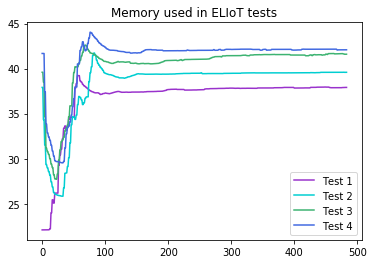

In [68]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER - 2):
    x = range(int(dict_test["times"]))
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
ax.set_title('Memory used in ELIoT tests')
plt.show()

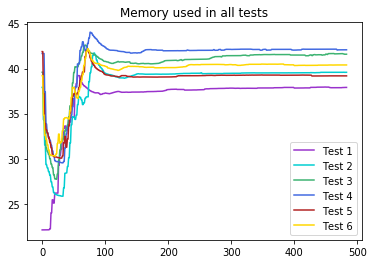

In [70]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER):
    x = range(int(dict_test["times"]))
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
ax.set_title('Memory used in all tests')
plt.show()